In [16]:
from trained_untrained_results_funcs import load_perf
import seaborn as sns
import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt

In [17]:
exp = ['384', '243']
br_labels_dict = {}
num_vox_dict = {}
subjects_dict = {}

data_processed_folder_pereira = f'/data/LLMs/data_processed/pereira/dataset'
data_processed_folder_fed = f'/data/LLMs/data_processed/fedorenko/dataset'
data_processed_folder_blank = f'/data/LLMs/data_processed/blank/dataset'

for e in exp:

    bre = np.load(f'{data_processed_folder_pereira}/networks_{e}.npy', allow_pickle=True)
    br_labels_dict[e] = bre
    num_vox_dict[e] = bre.shape[0]
    subjects_dict[e] = np.load(f"{data_processed_folder_pereira}/subjects_{e}.npy", allow_pickle=True)
    
lang_indices_dict = {}
lang_indices_384 = np.argwhere(br_labels_dict['384'] == 'language').squeeze()
lang_indices_243 = np.argwhere(br_labels_dict['243'] == 'language').squeeze()
lang_indices_dict['384'] = lang_indices_384
lang_indices_dict['243'] = lang_indices_243


subjects_arr_fed  = np.load(f"{data_processed_folder_fed}/subjects.npy", allow_pickle=True)
subjects_arr_blank  = np.load(f"{data_processed_folder_blank}/subjects.npy", allow_pickle=True)

subjects_arr_pereira = np.load(f"{data_processed_folder_pereira}/subjects_complete.npy", allow_pickle=True)
networks_arr_pereira = np.load(f"{data_processed_folder_pereira}/network_complete.npy", allow_pickle=True)
lang_indices = np.argwhere(networks_arr_pereira=='language').squeeze()

/tmp/ipykernel_763400/1599300919.py:95: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(layer_perf_pd_all_shuffled, x='layer_num', y='perf', hue='Model', errorbar=None, ax=ax[0], legend=legend, linewidth=3, palette=palette)
/tmp/ipykernel_763400/1599300919.py:97: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[0].legend(fontsize=25)  # Set legend font size for the first subplot
/tmp/ipykernel_763400/1599300919.py:95: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(layer_perf_pd_all_shuffled, x='layer_num', y='perf', hue='Model', errorbar=None, ax=ax[0], legend=legend, linewidth=3, palette=palette)
/tmp/ipykernel_763400/1599300919.py:97: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend(

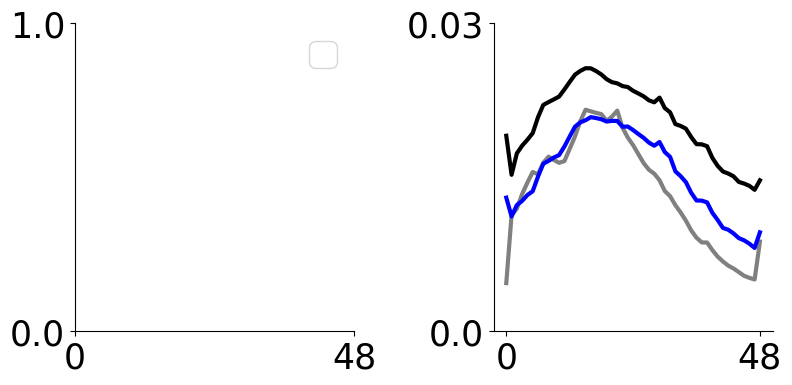

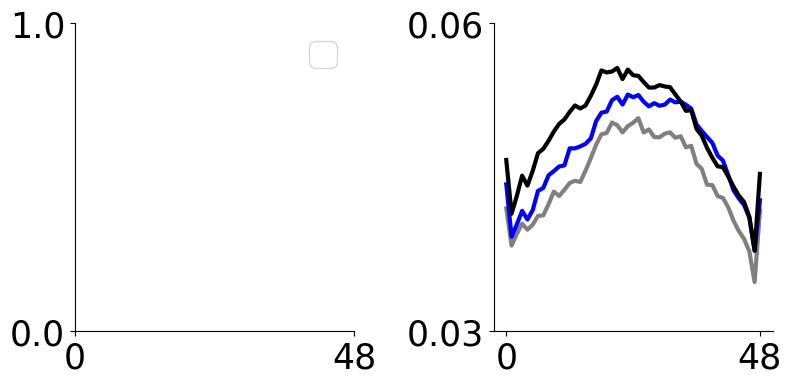

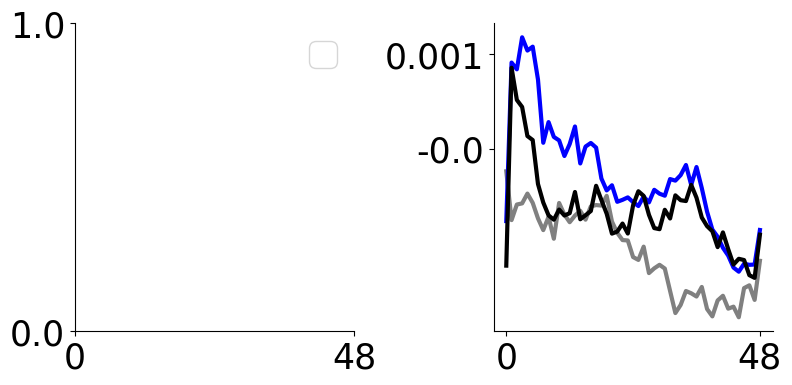

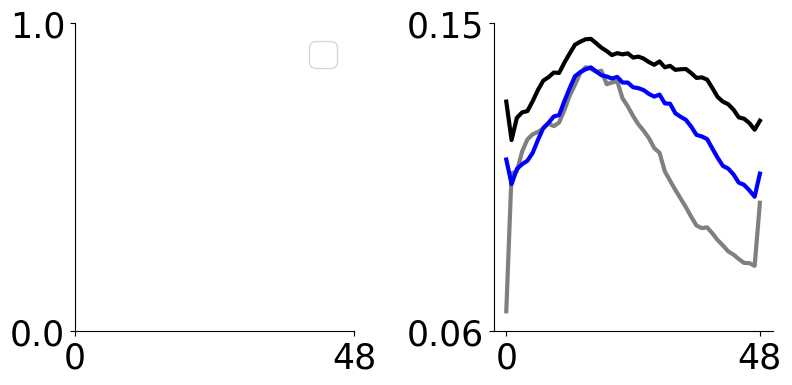

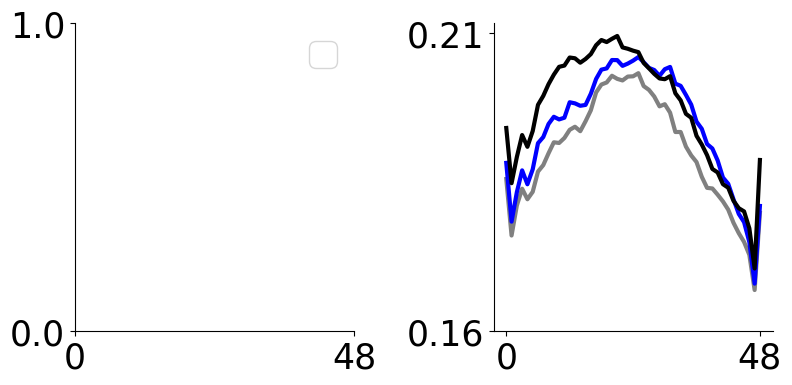

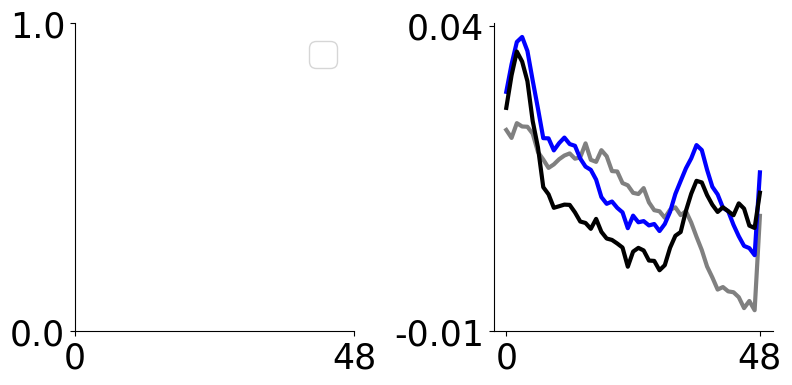

In [19]:
dataset_arr = ['pereira', 'fedorenko', 'blank']
perf_arr = ['out_of_sample_r2', 'pearson_r']
feature_extraction_arr = ['', '-mp', '-sp']
shuffled_arr = ['']
layer_pd_dict = {}
for dataset in dataset_arr:
    
    if dataset == 'pereira':
        exp_arr = ['243', '384']
        
    else:
        exp_arr = ['']
        
    for perf in perf_arr: 
        
        layer_perf_pd_all = {'perf': [], 'type': [], 'Model': [], 'Shuffled': [], 'layer_num': []}
        
        for i, fe in enumerate(feature_extraction_arr):
            
            for shuffled in shuffled_arr:
        
                for l in range(49):
                                
                    layer_perf_pd = {'perf': [], 'subjects': [], 'Network': []}
                    
                    for exp in exp_arr:
                        
                        if len(exp) > 0:
                            layer_perf =  load_perf(f'/data/LLMs/brainscore/results_{dataset}/{shuffled}/{dataset}_gpt2-xl{fe}_layer_{l}_1_{exp}.npz', perf)
                        else:
                            layer_perf =  load_perf(f'/data/LLMs/brainscore/results_{dataset}/{shuffled}/{dataset}_gpt2-xl{fe}_layer_{l}_1.npz', perf)
                        
                        num_vals = len(layer_perf)
                        
                        layer_perf_pd['perf'].extend(layer_perf)
                        
                        if dataset == 'pereira':
                            layer_perf_pd['Network'].extend(br_labels_dict[exp])
                            layer_perf_pd['subjects'].extend(subjects_dict[exp])
                            
                        elif dataset == 'fedorenko':
                            layer_perf_pd['Network'].extend(np.tile(['language'], num_vals))
                            layer_perf_pd ['subjects'].extend(subjects_arr_fed)
                            
                        else:
                            layer_perf_pd['Network'].extend(np.tile(['language'], num_vals))
                            layer_perf_pd['subjects'].extend(subjects_arr_blank)
                            
                    
                    layer_perf_pd = pd.DataFrame(layer_perf_pd)
                    layer_perf_pd = layer_perf_pd.loc[layer_perf_pd.Network=='language']
                    
                    perf_avg = np.median(layer_perf_pd.groupby(['subjects'])['perf'].median())
                    perf_avg_mean = np.mean(layer_perf_pd.groupby(['subjects'])['perf'].mean())              
                    layer_perf_pd_all['perf'].extend([perf_avg, perf_avg_mean])
                    layer_perf_pd_all['type'].extend(['median', 'mean'])
                    layer_perf_pd_all['Model'].extend([f"GPT2-XL{fe}", f"GPT2-XL{fe}"])
                    layer_perf_pd_all['Shuffled'].extend([f"{shuffled}", f"{shuffled}"])
                    layer_perf_pd_all['layer_num'].extend([f"{l}", f"{l}"])
                    
                
        layer_pd_dict[f"{dataset}_{perf}"] = pd.DataFrame(layer_perf_pd_all)  
        
# Save the dictionary to a pickle file
with open('/home2/ebrahim/beyond-brainscore/analyze_results/figures_code/figures_data/layer_pd_dict.pickle', 'wb') as f:
    pickle.dump(layer_pd_dict, f)
    
# Create a custom palette with more distinct shades of blue
palette = sns.color_palette(["gray", "blue", 'black'])

c = 0
for perf in perf_arr:
    for i, dataset in enumerate(dataset_arr):
        
        fig, ax = plt.subplots(1,2, figsize=(9,4))
        plt.subplots_adjust(wspace=0.5)  # Decrease wspace to reduce the horizontal space between plots
        
        layer_pd_perf_data = layer_pd_dict[f"{dataset}_{perf}"]
        
        layer_perf_pd_all_shuffled = layer_pd_perf_data.loc[layer_pd_perf_data['Shuffled']=='shuffled']
        layer_perf_pd_all_shuffled = layer_perf_pd_all_shuffled.loc[layer_perf_pd_all_shuffled['type']=='mean']

        layer_perf_pd_all = layer_pd_perf_data.loc[layer_pd_perf_data['Shuffled']=='']
        layer_perf_pd_all = layer_perf_pd_all.loc[layer_perf_pd_all['type']=='mean']

        sns.despine()
        
        if c == 0:
            legend = False
        else:
            legend = False
            
        c = 1
        
        sns.lineplot(layer_perf_pd_all_shuffled, x='layer_num', y='perf', hue='Model', errorbar=None, ax=ax[0], legend=legend, linewidth=3, palette=palette)
        sns.lineplot(layer_perf_pd_all, x='layer_num', y='perf', hue='Model', errorbar=None, ax=ax[1], legend=False, linewidth=3, palette=palette)
        ax[0].legend(fontsize=25)  # Set legend font size for the first subplot
        
        ax[0].set_xticks([0,48])
        ax[0].set_xticklabels([0,48], fontsize=25)
        
        ax[1].set_xticks([0,48])
        ax[1].set_xticklabels([0,48], fontsize=25)
        ax[0].set_ylabel('')
        ax[0].set_xlabel('')
        ax[1].set_ylabel('')
        ax[1].set_xlabel('')
        
        ax[0].set_yticks((round(float(ax[0].get_ylim()[0]),2), round(float(ax[0].get_ylim()[1]),2)))
        ax[0].set_yticklabels(((round(float(ax[0].get_ylim()[0]),2)), round(float(ax[0].get_ylim()[1]),2)), fontsize=25)
        
        if dataset == 'blank':
            round_val = 3
        else:
            round_val = 2
            
        ax[1].set_yticks(((round(float(ax[1].get_ylim()[0]),2), round(float(ax[1].get_ylim()[1]),round_val))))
        ax[1].set_yticklabels(((round(float(ax[1].get_ylim()[0]),2)), round(float(ax[1].get_ylim()[1]),round_val)), fontsize=25)
        layer_perf_pd_all_shuffled.to_csv(f'/home2/ebrahim/beyond-brainscore/analyze_results/figures_code/figures_data/figure2/{dataset}_{perf}_shuffled.csv')
        layer_perf_pd_all.to_csv(f'/home2/ebrahim/beyond-brainscore/analyze_results/figures_code/figures_data/figure2/{dataset}_{perf}.csv')
        #fig.savefig(f'/home2/ebrahim/beyond-brainscore/analyze_results/figures_code/figures/new_figures/figure2/across_layer/{dataset}_{perf}.png')
        #fig.savefig(f'/home2/ebrahim/beyond-brainscore/analyze_results/figures_code/figures/new_figures/figure2/across_layer/{dataset}_{perf}.pdf', bbox_inches='tight')
        #plt.show()
        
    